In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [43]:
# Load data
#parsing date and setting the 'date' column as the index
#resampling data to daily frequency 

df = pd.read_csv("data-train.csv", parse_dates=["date"], index_col = "date").asfreq("D")
df

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,NaN,0.0
2022-06-14,79,11.813969,0.0


In [44]:
# same to do unseen data
unseen = pd.read_csv("data-unseen-features.csv", parse_dates=["date"], index_col = "date").asfreq("D")
unseen

,temperature,media_spend
date,,
2022-06-17,11.923126,0.000000
2022-06-18,14.986238,0.000000
2022-06-19,11.003947,0.000000
2022-06-20,12.699259,0.000000
2022-06-21,17.852300,0.000000
2022-06-22,11.601299,0.000000
2022-06-23,16.207998,14.847883
2022-06-24,12.952067,0.000000
2022-06-25,9.284319,14.664207


In [45]:
# Looking data shape
df.shape, unseen.shape

((776, 3), (14, 2))

In [46]:
corr_df =df[['temperature', 'media_spend', 'orders']].corr(method='spearman')
corr_unseen = unseen[['temperature', 'media_spend']].corr(method='spearman')
print('train data correlation:','\n',corr_df)
print('train data correlation:','\n',corr_unseen)


train data correlation: 
              temperature  media_spend    orders
temperature     1.000000     0.023737  0.715629
media_spend     0.023737     1.000000  0.199126
orders          0.715629     0.199126  1.000000
train data correlation: 
              temperature  media_spend
temperature     1.000000    -0.069886
media_spend    -0.069886     1.000000


There is a moderately strong positive correlation (0.716) between temperature and orders, indicating that as temperature increases, the number of orders tends to increase.

In [47]:
# Check for missing values
df.isnull().sum()

orders          0
temperature    20
media_spend     0
dtype: int64

In [48]:
unseen.isnull().sum()

temperature    1
media_spend    0
dtype: int64

In [49]:
#interpolating missing values
df['temperature'] = df['temperature'].interpolate()
unseen['temperature'] = unseen['temperature'].interpolate()

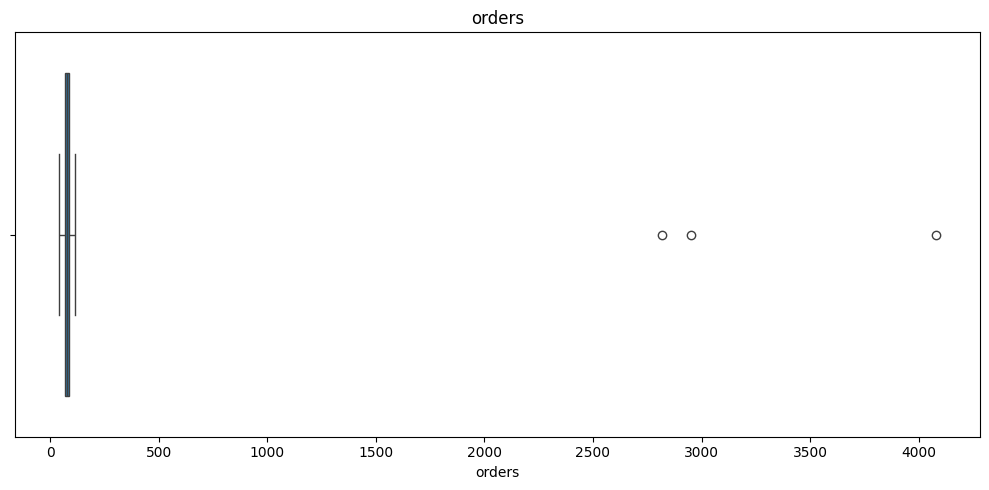

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

sns.boxplot(x=df["orders"])
plt.title("orders")
plt.tight_layout()
plt.show()


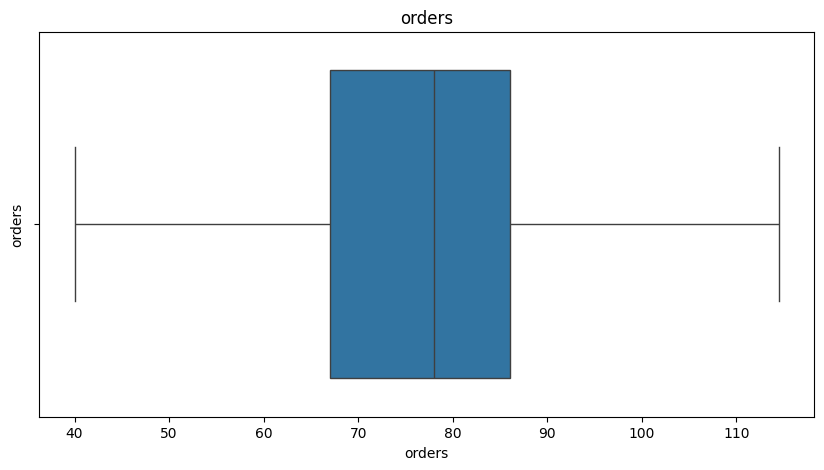

In [51]:

# Determine lower and upper bounds for the "orders" column
q1 = df['orders'].quantile(0.25)
q3 = df['orders'].quantile(0.75)
IQR = q3 - q1
lower_limit = q1 - 1.5 * IQR
upper_limit = q3 + 1.5 * IQR

# Replace values lower than the lower bound with the lower bound
df['orders'] = df['orders'].apply(lambda x: lower_limit if x < lower_limit else x)

# Replace values higher than the upper bound with the upper bound
df['orders'] = df['orders'].apply(lambda x: upper_limit if x > upper_limit else x)

# Create a boxplot for the "orders" feature
sns.boxplot(df['orders'], orient='h')
plt.ylabel('orders')
plt.title('orders')
plt.show()



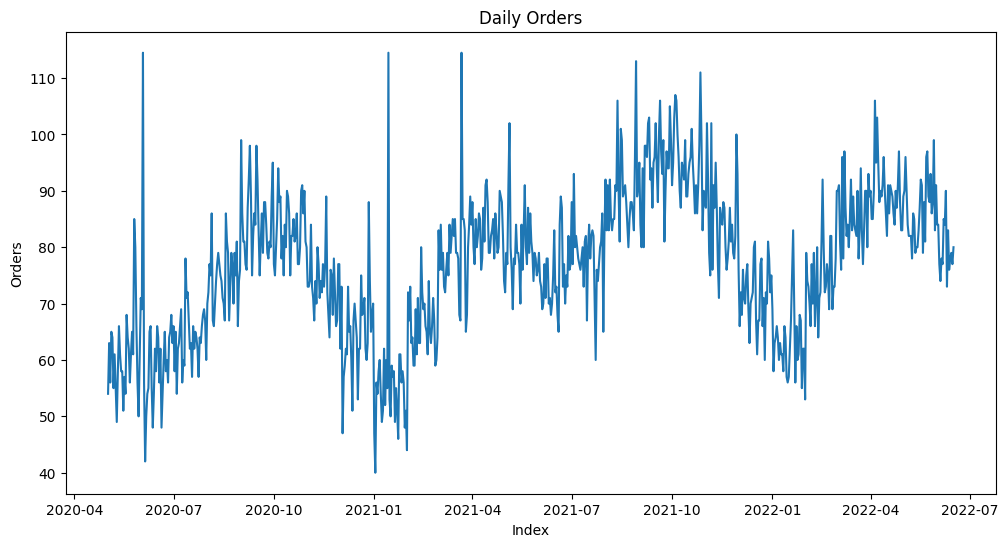

In [52]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plot the 'orders' column from the DataFrame
plt.plot(df['orders'])

# Label the x-axis, y-axis
plt.xlabel('Index')
plt.ylabel('Orders')

# Set the title of the plot
plt.title('Daily Orders')

# Display the plot
plt.show()



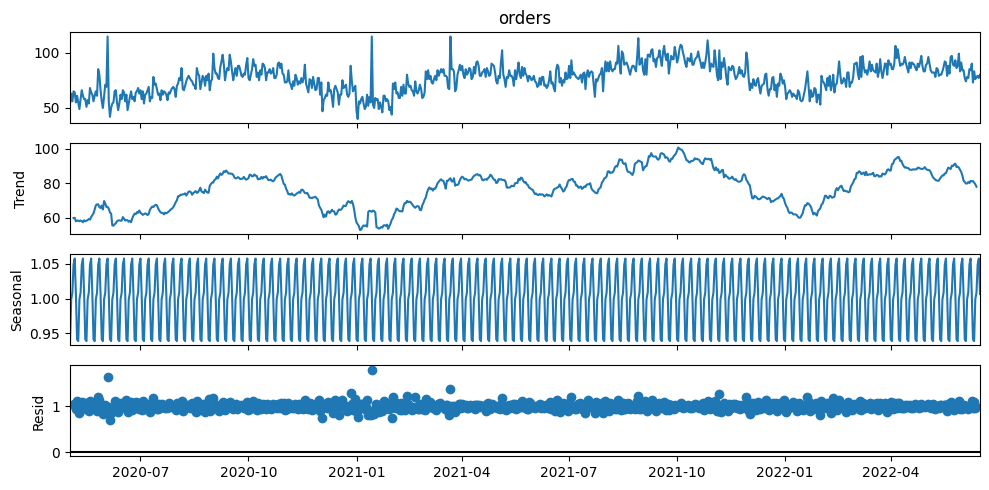

In [53]:
dec_df = seasonal_decompose(df.orders, model="mul", period=7).plot()

In [54]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df["orders"])
print(adf[1])

0.09704356291982746


In this case, the p-value returned is approximately 0.097, which is greater than the commonly used significance level of 0.05.
Interpreting the result:
If the p-value is less than the significance level (commonly chosen as 0.05), then we reject the null hypothesis (the data has a unit root, indicating non-stationarity), and the data is considered stationary.
If the p-value is greater than the significance level, we fail to reject the null hypothesis, meaning there is insufficient evidence to conclude that the data is stationary. (Bu durumda, yaklaşık olarak 0.097 olan p-değeri kullanılmıştır, bu değer genellikle 0.05 olarak belirlenen yaygın anlamlılık düzeyinden daha büyüktür.
Sonucun yorumu:
P-değeri, anlamlılık düzeyinden (genellikle 0.05 olarak seçilir) daha küçükse, null hipotezi reddederiz (verinin bir birim kökü olduğu, yani durağan olmadığı anlamına gelir) ve veri durağan olarak kabul edilir.
P-değeri, anlamlılık düzeyinden büyükse, null hipotezini reddedemeyiz, bu da verinin durağan olduğuna dair yeterli kanıt olmadığı anlamına gelir.)

In [55]:
# Making the data stationary by taking the first difference
df1 = df.diff().dropna()

# Applying ADF test again
adf_test = adfuller(df1["orders"])
p_value = adf_test[1]

# Printing the p-value
print(p_value)


3.580446372152211e-13


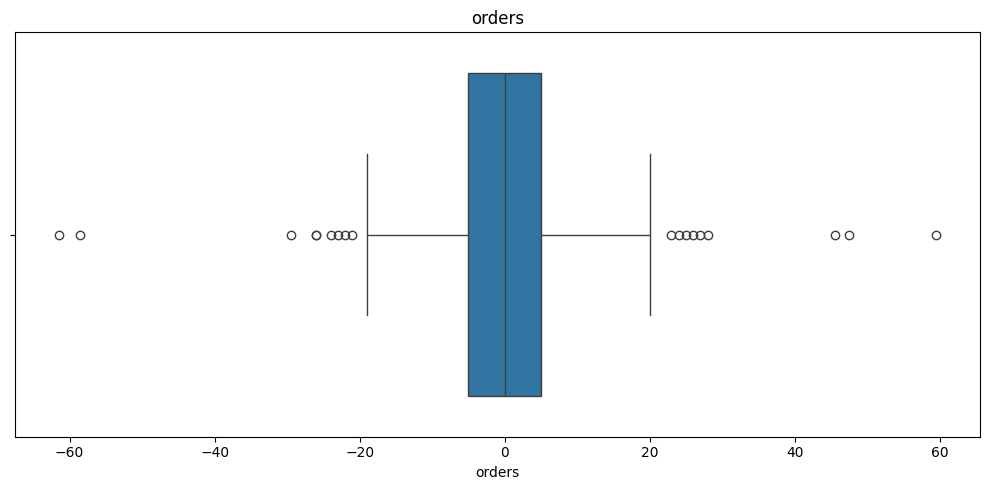

In [56]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

sns.boxplot(x=df1["orders"])
plt.title("orders")
plt.tight_layout()
plt.show()

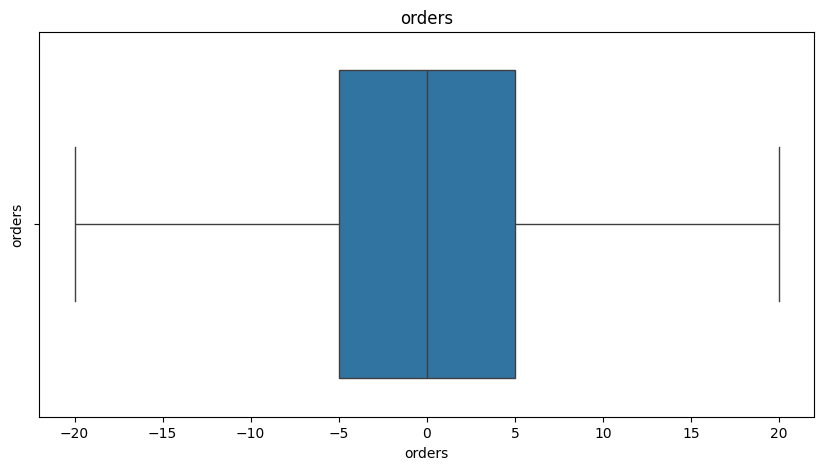

In [57]:
# Determine lower and upper bounds for the "orders" column
q1 = df1['orders'].quantile(0.25)
q3 = df1['orders'].quantile(0.75)
IQR = q3 - q1
lower_limit = q1 - 1.5 * IQR
upper_limit = q3 + 1.5 * IQR

# Replace values lower than the lower bound with the lower bound
df1['orders'] = df1['orders'].apply(lambda x: lower_limit if x < lower_limit else x)

# Replace values higher than the upper bound with the upper bound
df1['orders'] = df1['orders'].apply(lambda x: upper_limit if x > upper_limit else x)

# Create a boxplot for the "orders" feature
sns.boxplot(df1['orders'], orient='h')
plt.ylabel('orders')
plt.title('orders')
plt.show()


it's a very small value. So, the result suggests that the "orders" data becomes stationary after taking the first difference.

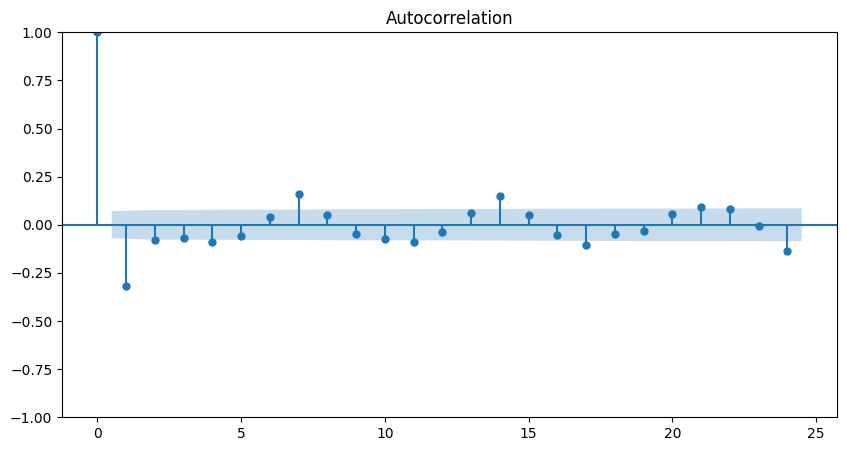

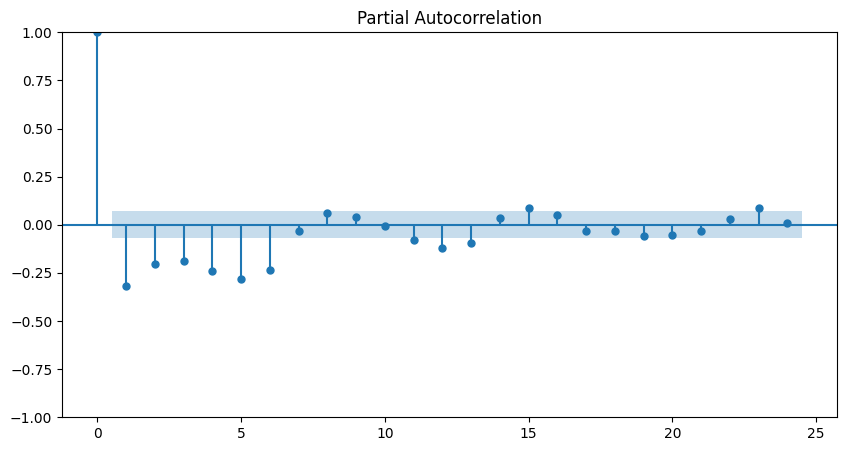

In [58]:
fig = plot_acf(df1["orders"], lags=24)
fig = plot_pacf(df1["orders"], lags=24)

In [59]:
train, test = df[:-14], df[-14:]
print(train)
print(test)

            orders  temperature  media_spend
date                                        
2020-05-02    54.0    18.270322          0.0
2020-05-03    63.0    19.882444          0.0
2020-05-04    56.0    16.878095          0.0
2020-05-05    65.0    21.878648          0.0
2020-05-06    64.0    21.112398          0.0
...            ...          ...          ...
2022-05-29    99.0    27.259745          0.0
2022-05-30    83.0    15.389206          0.0
2022-05-31    91.0    18.351899          0.0
2022-06-01    84.0    10.141080          0.0
2022-06-02    84.0    12.854688          0.0

[762 rows x 3 columns]
            orders  temperature  media_spend
date                                        
2022-06-03    77.0    14.021126          0.0
2022-06-04    74.0     8.557476          0.0
2022-06-05    78.0    12.326819          0.0
2022-06-06    77.0    14.085052          0.0
2022-06-07    85.0     9.062854          0.0
2022-06-08    84.0    11.424545          0.0
2022-06-09    90.0    19.228510

In [19]:
#pip install pmdarima

In [25]:
import pmdarima as pm

# Automatically select ARIMA model using auto_arima function
model = pm.auto_arima(train["orders"], 
                      seasonal=True,  # Indicates that the model should consider seasonality
                      m=7,           # Seasonal cycle length
                      d=0, D=0,       # Non-seasonal and seasonal differencing orders
                     max_p=4, max_q=4,     # Maximum AR and MA orders
                      max_P=4, max_Q=4,     # Maximum seasonal AR and MA orders
                      trace=True,           # Print status updates during fitting
                      error_action='ignore',      # Ignore errors during fitting
                      suppress_warnings=True)    # Suppress warnings during fitting

# Print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6068.695, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5376.038, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5581.218, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=8802.909, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=5432.737, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5315.449, Time=0.77 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=5303.269, Time=1.86 sec
 ARIMA(1,0,0)(4,0,0)[7] intercept   : AIC=5289.143, Time=3.85 sec
 ARIMA(1,0,0)(4,0,1)[7] intercept   : AIC=5288.697, Time=4.34 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=5293.221, Time=2.86 sec
 ARIMA(1,0,0)(4,0,2)[7] intercept   : AIC=5295.519, Time=4.43 sec
 ARIMA(1,0,0)(3,0,2)[7] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(0,0,0)(4,0,1)[7] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(2,0,0)(4,0,1)[7] intercept   : AIC=5249.9

Best model:  ARIMA(1,1,1)(4,1,0)[7]
Best model:  ARIMA(4,1,0)(4,1,0)[7] 
Best model:  ARIMA(1,0,1)(0,0,4)[7] 
Best model:  ARIMA(1,1,1)(0,0,4)[7] 
Best model:  ARIMA(4,3,0)(4,3,0)[7]      

                                     SARIMAX Results                                      
Dep. Variable:                             orders   No. Observations:                  762
Model:             SARIMAX(1, 1, 1)x(4, 0, [], 7)   Log Likelihood               -2584.327
Date:                            Mon, 12 Feb 2024   AIC                           5182.653
Time:                                    00:13:44   BIC                           5215.096
Sample:                                05-02-2020   HQIC                          5195.146
                                     - 06-02-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1696      0.033      5.123      0.000       0.105       0.234
ma.L1         -0.8841      0.021   

C:\Users\DELL\AppData\Local\Temp\ipykernel_22104\4187141730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fitted"] = fitted


<Axes: xlabel='date'>

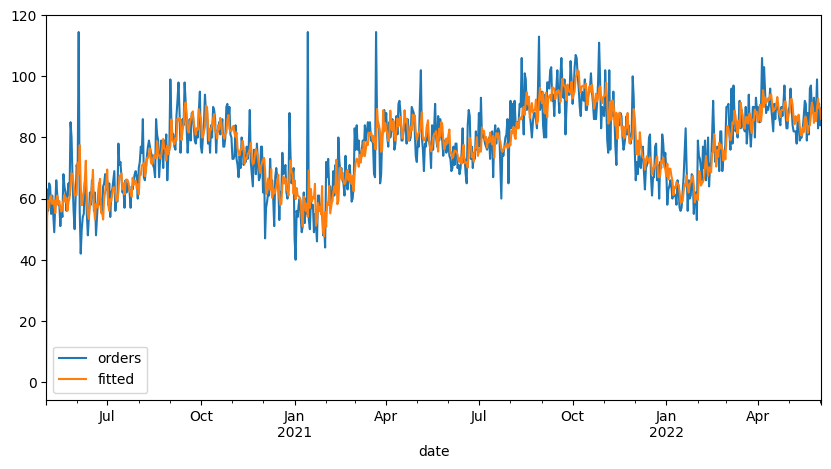

In [63]:
best_model = SARIMAX(train["orders"], order=(1,1,1), seasonal_order=(4,0,0,7), trend='n').fit()
print(best_model.summary())
fitted = best_model.predict()
train["fitted"] = fitted
train[["orders","fitted"]].plot()

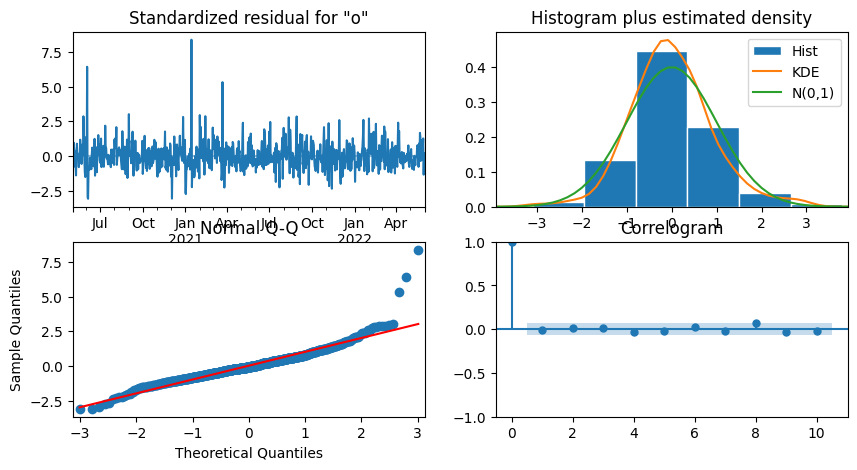

In [64]:
plt = best_model.plot_diagnostics()

C:\Users\DELL\AppData\Local\Temp\ipykernel_22104\2495089283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["preds"] = preds


<Axes: xlabel='date'>

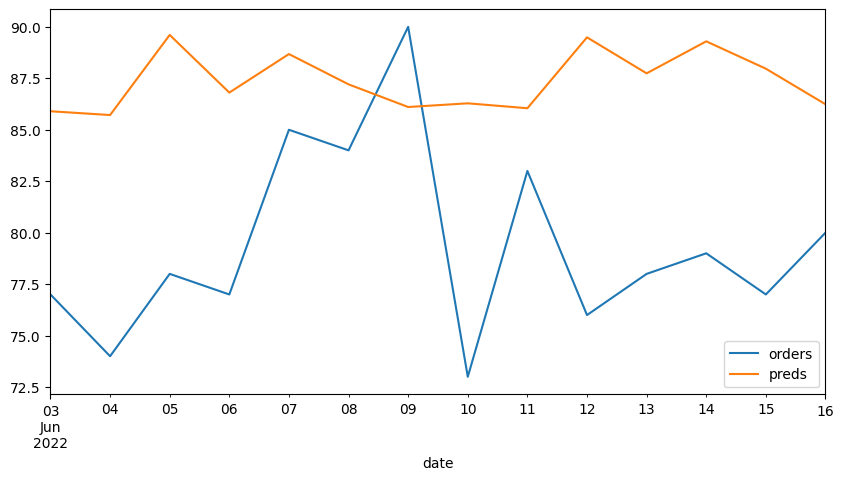

In [65]:
preds = best_model.forecast(steps=len(test))
test["preds"] = preds
test[["orders","preds"]].plot()

In [66]:
# Calculate residuals and forecast errors
resids = best_model.resid
forecast_errors = test["orders"] - test['preds']

# Compute error metrics for residuals
mae_residuals = np.mean(np.abs(resids))
mse_residuals = np.mean(np.square(resids))
rmse_residuals = np.sqrt(np.mean(np.square(resids)))

# Compute error metrics for forecast errors
mae_forecast_errors = np.mean(np.abs(forecast_errors))
mse_forecast_errors = np.mean(np.square(forecast_errors))
rmse_forecast_errors = np.sqrt(np.mean(np.square(forecast_errors)))

# Print the results
print("Metrics for Residuals:")
print("MAE:", mae_residuals)
print("MSE:", mse_residuals)
print("RMSE:", rmse_residuals)
print()
print("Metrics for Forecast Errors:")
print("MAE:", mae_forecast_errors)
print("MSE:", mse_forecast_errors)
print("RMSE:", rmse_forecast_errors)


Metrics for Residuals:
MAE: 5.213320629672168
MSE: 55.86464327904499
RMSE: 7.474265400629348

Metrics for Forecast Errors:
MAE: 8.56177337443127
MSE: 86.71620562909784
RMSE: 9.31215365149748


In [67]:
train_preds = best_model.forecast(steps=len(df))
train_preds

2022-06-03    85.899513
2022-06-04    85.715362
2022-06-05    89.605856
2022-06-06    86.805827
2022-06-07    88.676707
                ...    
2024-07-13    88.247798
2024-07-14    88.247798
2024-07-15    88.247798
2024-07-16    88.247798
2024-07-17    88.247798
Freq: D, Name: predicted_mean, Length: 776, dtype: float64

In [68]:
# Generate the forecasted values
unseen_preds = best_model.forecast(steps=len(unseen))

# Create a date range starting from the next day after the last date in the training data
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=len(unseen), freq='D')

# Create a DataFrame with the forecasted values and the corresponding dates
forecast_df = pd.DataFrame({"date": forecast_dates, "orders": unseen_preds})

# Set the date column as the index
forecast_df.set_index("date", inplace=True)

# Print the forecasted DataFrame
forecast_df


,orders
date,
2022-06-17,85.899513
2022-06-18,85.715362
2022-06-19,89.605856
2022-06-20,86.805827
2022-06-21,88.676707
2022-06-22,87.206222
2022-06-23,86.104680
2022-06-24,86.284248
2022-06-25,86.045740


In [69]:
# Reset the index to turn the "Date" column into a regular column
preds_df = forecast_df.reset_index()

# Print the DataFrame
preds_df


,date,orders
0,2022-06-17,85.899513
1,2022-06-18,85.715362
2,2022-06-19,89.605856
3,2022-06-20,86.805827
4,2022-06-21,88.676707
5,2022-06-22,87.206222
6,2022-06-23,86.104680
7,2022-06-24,86.284248
8,2022-06-25,86.045740
9,2022-06-26,89.488687


In [41]:
preds_df.to_csv('submission.csv', index=None)